#**Importing libraries**

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

In [ ]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
warnings.filterwarnings("ignore")

#**Connecting to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/trash_images'

#**Data preprocessing**

In [ ]:
# Data Classes
print(os.listdir(data_path))

['plastic', 'trash', 'paper', 'cardboard', 'metal', 'glass']


In [ ]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
trash_images,0
plastic,482
trash,147
paper,594
cardboard,403
metal,410
glass,501


In [ ]:
print(f'Total {count.sum()}')

Total File Count    2537
dtype: int64


In [ ]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

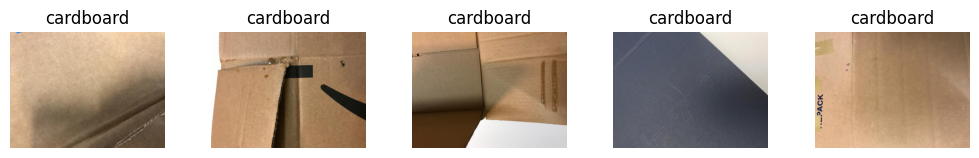

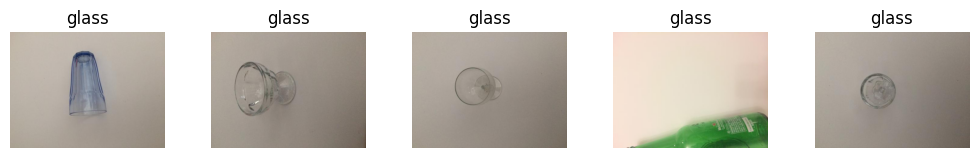

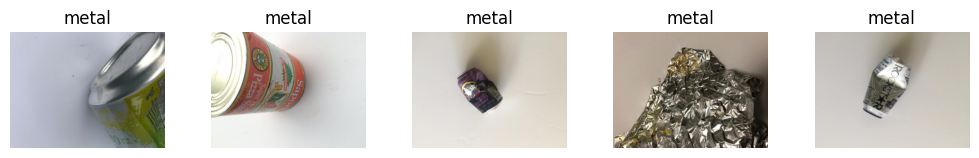

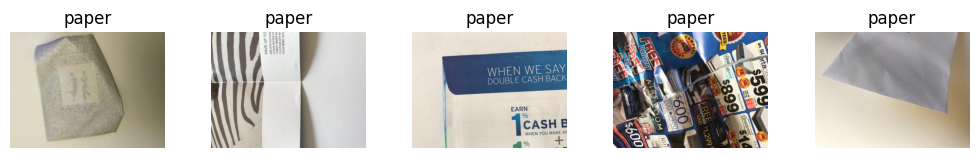

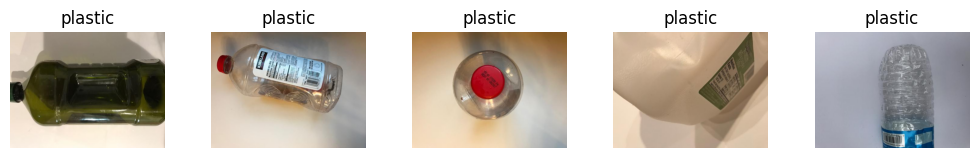

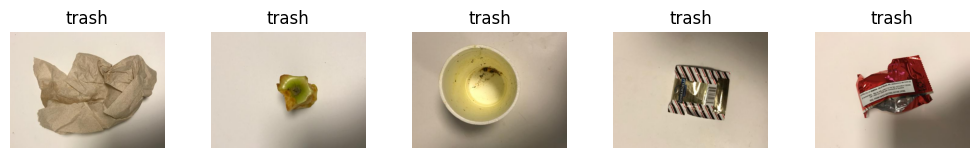

In [ ]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

#**Xception**

Found 2158 images belonging to 6 classes.
Found 379 images belonging to 6 classes.
83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_25 (Dense)            (None, 128)               262272    
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                     

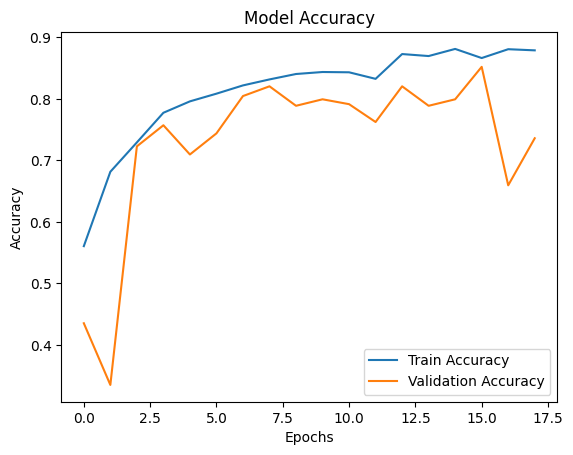

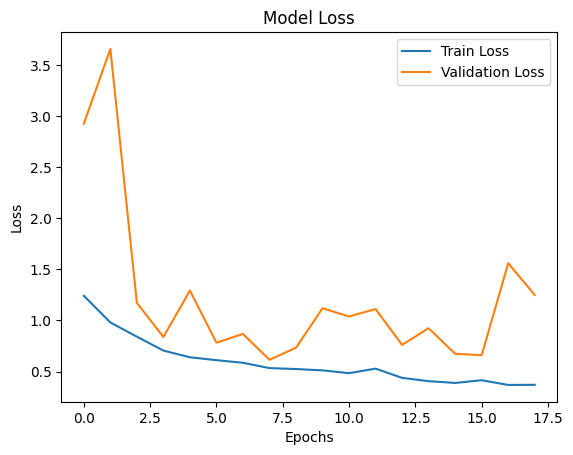

Best Validation Accuracy: 0.8522427678108215


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

# Define variables for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Separate train Data
train_data = train_datagen.flow_from_directory(
    data_path,
    subset="training",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Separate validation Data
validation_data = test_datagen.flow_from_directory(
    data_path,
    subset="validation",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Xception Model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
model_checkpoint = ModelCheckpoint('trash_xception.h5', monitor='val_loss', mode='min', save_best_only=True)

# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Model training
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=500,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy}")


#**EfficientNet**

Found 2158 images belonging to 6 classes.
Found 379 images belonging to 6 classes.
16804768/16804768 [==============================] - 1s 0us/step
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 6, 6, 1280)        4049564   
 l)                                                              
                                                                 
 flatten_8 (Flatten)         (None, 46080)             0         
                                                                 
 dense_28 (Dense)            (None, 128)               5898368   
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                     

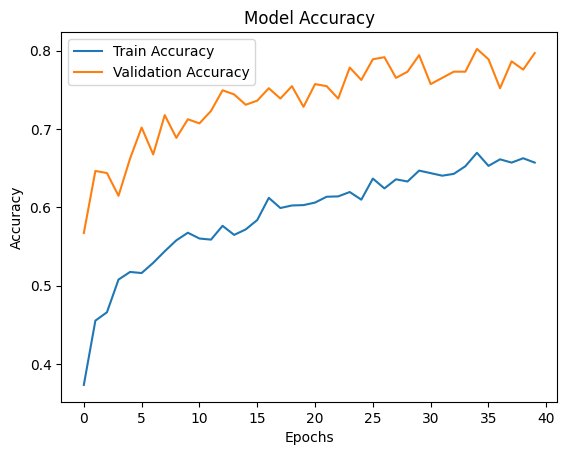

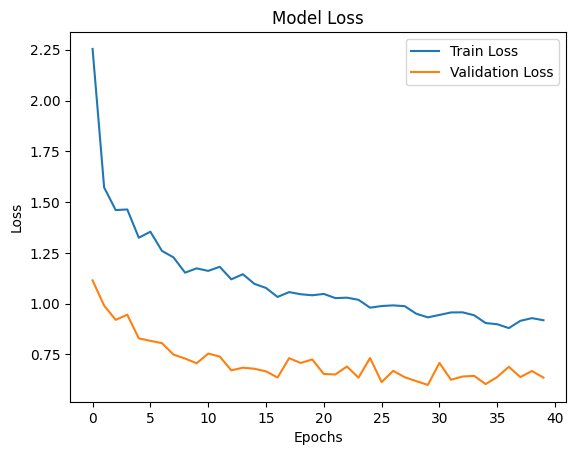

Best Validation Accuracy: 0.8021107912063599


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define variables for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Separate train Data
train_data = train_datagen.flow_from_directory(
    data_path,
    subset="training",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Separate validation Data
validation_data = test_datagen.flow_from_directory(
    data_path,
    subset="validation",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# EfficientNet model
base_model = EfficientNetB0(input_shape=(target_size[0], target_size[1], 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
model_checkpoint = ModelCheckpoint('trash_efficientnet.h5', monitor='val_loss', mode='min', save_best_only=True)

# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Model training
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=500,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy}")


#**VGG16 (Visual Geometry Group 16)**

Found 2158 images belonging to 6 classes.
Found 379 images belonging to 6 classes.
58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0         
                                                                 
 dense_22 (Dense)            (None, 128)               1638528   
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 6

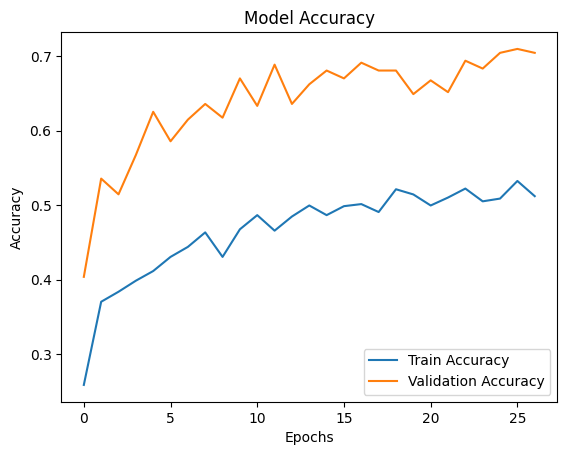

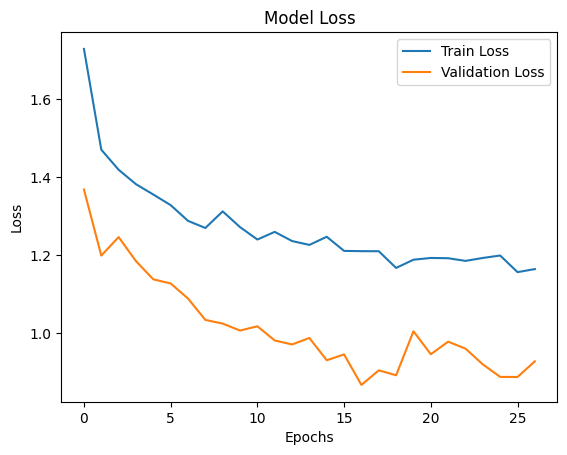

Best Validation Accuracy: 0.7097625136375427


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define variables for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Separate train Data
train_data = train_datagen.flow_from_directory(
    data_path,
    subset="training",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Separate validation Data
validation_data = test_datagen.flow_from_directory(
    data_path,
    subset="validation",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the layers of the pre-trained VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
model_checkpoint = ModelCheckpoint('vgg16_trash.h5', monitor='val_loss', mode='min', save_best_only=True)

# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Model training
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=500,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy}")


#**PNASNet (Progressive Neural Architecture Search)**

Found 2158 images belonging to 6 classes.
Found 379 images belonging to 6 classes.
19993432/19993432 [==============================] - 1s 0us/step
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 6, 6, 1056)        4269716   
                                                                 
 global_average_pooling2d_1  (None, 1056)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_34 (Dense)            (None, 128)               135296    
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                     

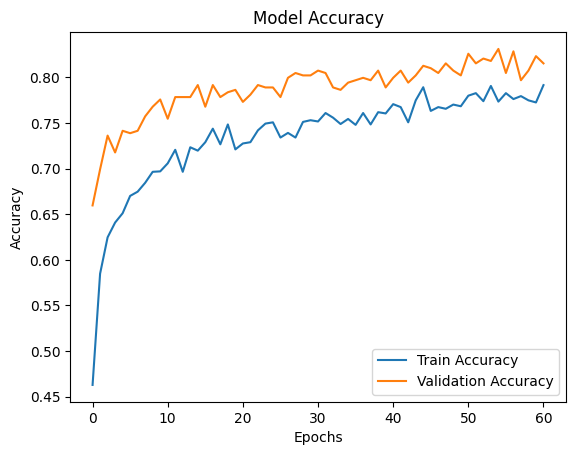

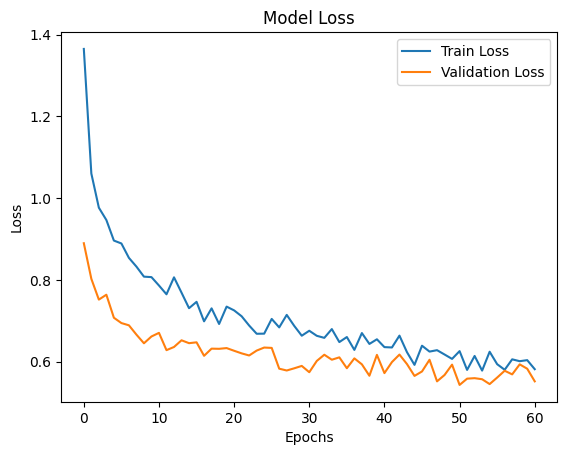

Best Validation Accuracy: 0.831134557723999


In [ ]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define variables for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Separate train Data
train_data = train_datagen.flow_from_directory(
    data_path,
    subset="training",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Separate validation Data
validation_data = test_datagen.flow_from_directory(
    data_path,
    subset="validation",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Load NASNetMobile pre-trained on ImageNet
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with PNASNet architecture
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
model_checkpoint = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Model training
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=500,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy}")


#**MobileNetV2**

Found 2158 images belonging to 6 classes.
Found 379 images belonging to 6 classes.


9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_9 (Flatten)         (None, 46080)             0         
                                                                 
 dense_31 (Dense)            (None, 128)               5898368   
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 6)                 3

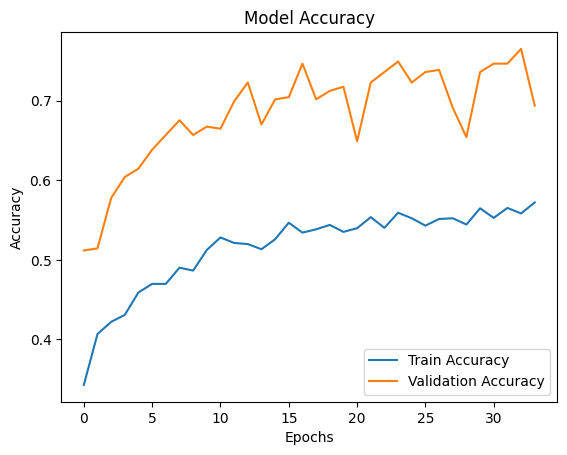

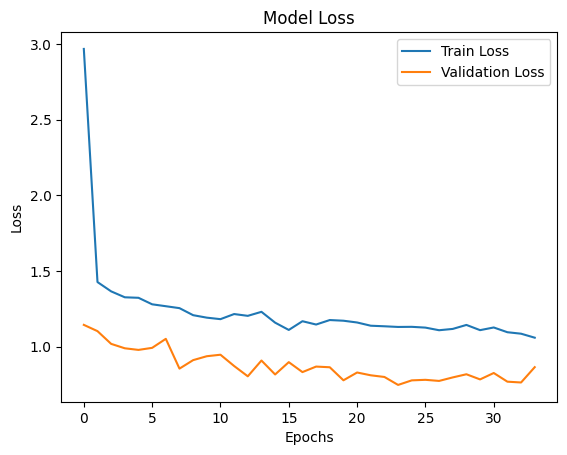

Best Validation Accuracy: 0.7651715278625488


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

# Define variables for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Separate train Data
train_data = train_datagen.flow_from_directory(
    data_path,
    subset="training",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Separate validation Data
validation_data = test_datagen.flow_from_directory(
    data_path,
    subset="validation",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
model_checkpoint = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Model training
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=500,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy}")


#**Convolutional Neural Network(CNN)**

Found 2158 images belonging to 6 classes.
Found 379 images belonging to 6 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPadd  (None, 182, 182, 3)       0         
 ing2D)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 88, 88, 64)        18496     
                                     

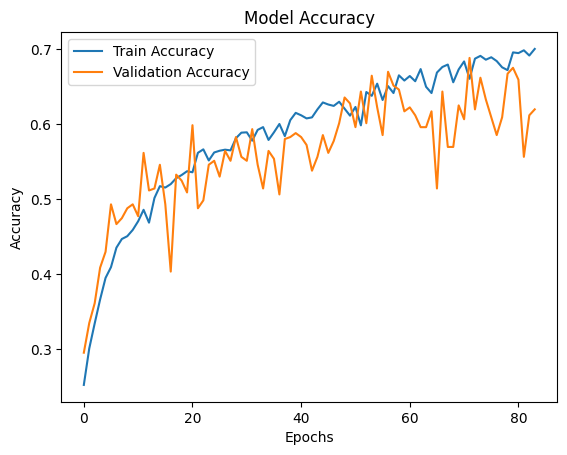

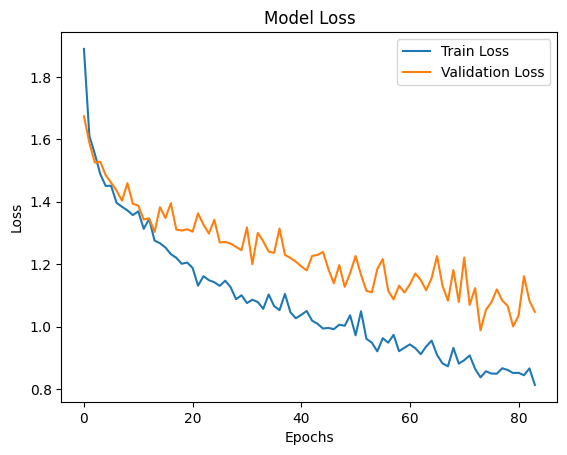

Best Validation Accuracy: 0.688654363155365


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

# Define variables for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Separate train Data
train_data = train_datagen.flow_from_directory(
    data_path,
    subset="training",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Separate validation Data
validation_data = test_datagen.flow_from_directory(
    data_path,
    subset="validation",
    seed=133,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Model
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
model_checkpoint = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Model training
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=500,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy}")
